In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
feature_names = [
    'dst_port','dst_asn','quic_ver','dur','ratio','flow_pkt_rate','flow_byte_rate',
    'total_pkts','total_bytes','max_bytes','min_bytes','ave_bytes','std_bytes','var_bytes',
    'fwd_pkts','fwd_bytes','max_fwd_bytes','min_fwd_bytes','ave_fwd_bytes','std_fwd_bytes','var_fwd_bytes',
    'rev_pkts','rev_bytes','max_rev_bytes','min_rev_bytes','ave_rev_bytes','std_rev_bytes','var_rev_bytes',
    'max_iat','min_iat','ave_iat','std_iat','var_iat','fwd_dur','max_fwd_iat','min_fwd_iat','ave_fwd_iat',
    'std_fwd_iat','var_fwd_iat','rev_dur','max_rev_iat','min_rev_iat','ave_rev_iat','std_rev_iat','var_rev_iat'
]

In [ ]:
def fill_missing_rows(df, interval=10000):
    new_rows = []
    new_index = []
    
    index_list = df.index.to_list()
    
    for i in range(len(index_list) - 1):
        current_idx = index_list[i]
        next_idx = index_list[i + 1]
        row_data = df.loc[current_idx]
        
        # Always keep the current row
        new_index.append(current_idx)
        new_rows.append(row_data)

        # Fill in missing indices
        gap = next_idx - current_idx
        if gap > interval:
            num_missing = (gap // interval) - 1
            for j in range(num_missing):
                new_idx = current_idx + interval * (j + 1)
                new_index.append(new_idx)
                new_rows.append(row_data.copy())  # Copy previous row

    # Add the last original row
    new_index.append(index_list[-1])
    new_rows.append(df.loc[index_list[-1]])

    # Create the new DataFrame
    df_filled = pd.DataFrame(new_rows, index=new_index)
    return df_filled

In [25]:
def get_ranking_matrix(filled_df, n=10):
    counts = pd.Series(filled_df.values.flatten()).value_counts()
    
    # uncomment if you only want top n rows
    # top_cols_idx = counts.iloc[:n]
    top_cols_idx = counts
    idx_to_show = list(top_cols_idx.index)

    important_features = [feature_names[i] for i in idx_to_show]

    ranking_matrix = pd.DataFrame(0, index=important_features, columns=range(len(filled_df)))

    for col_idx, selected_features in filled_df.iterrows():
        for rank, feature_num in enumerate(selected_features.dropna()):
            feature_num = int(feature_num)
            if feature_num in idx_to_show:
                feature_name = feature_names[feature_num]
                ranking_matrix.at[feature_name, col_idx] = len(selected_features) - rank

    ranking_matrix = ranking_matrix.loc[:, (ranking_matrix != 0).any(axis=0)]
    return ranking_matrix

In [23]:
def plot_heatmap(ranking_matrix):
    plt.figure(figsize=(20, 7))
    sns.heatmap(ranking_matrix, cbar=False, cmap="Greys", linewidths=0.5, linecolor='lightgray', square=True)

    plt.xlabel('Sample Windows')
    plt.ylabel('Features')
    plt.title('Feature Selection Over Sample Windows')

    shifted_labels = ranking_matrix.columns + 10100

    plt.xticks(
        ticks=np.arange(ranking_matrix.shape[1]),
        labels=shifted_labels,
        rotation=45
    )
    plt.yticks(rotation=0)
    plt.tight_layout()

    plt.show()

### OFS

In [3]:
ofs_df = pd.read_csv('sel_features_ofs.csv', header=None)

In [4]:
# Removes consecutive duplicates
ofs_filtered = ofs_df[(ofs_df != ofs_df.shift()).any(axis=1)]
ofs_filtered

,0,1,2,3,4
0,13,20,1,8,15
9900,27,13,6,20,1
19900,6,13,8,22,1
29900,38,32,20,13,27
39900,6,13,8,22,5
49900,6,13,8,22,1
69900,20,13,27,6,1
79900,6,13,8,22,5
89900,6,13,27,8,22
109900,6,20,13,27,8


In [16]:
ofs_filled = fill_missing_rows(ofs_filtered)
ofs_filled

,0,1,2,3,4
0,13,20,1,8,15
9900,27,13,6,20,1
19900,6,13,8,22,1
29900,38,32,20,13,27
39900,6,13,8,22,5
49900,6,13,8,22,1
59900,6,13,8,22,1
69900,20,13,27,6,1
79900,6,13,8,22,5
89900,6,13,27,8,22


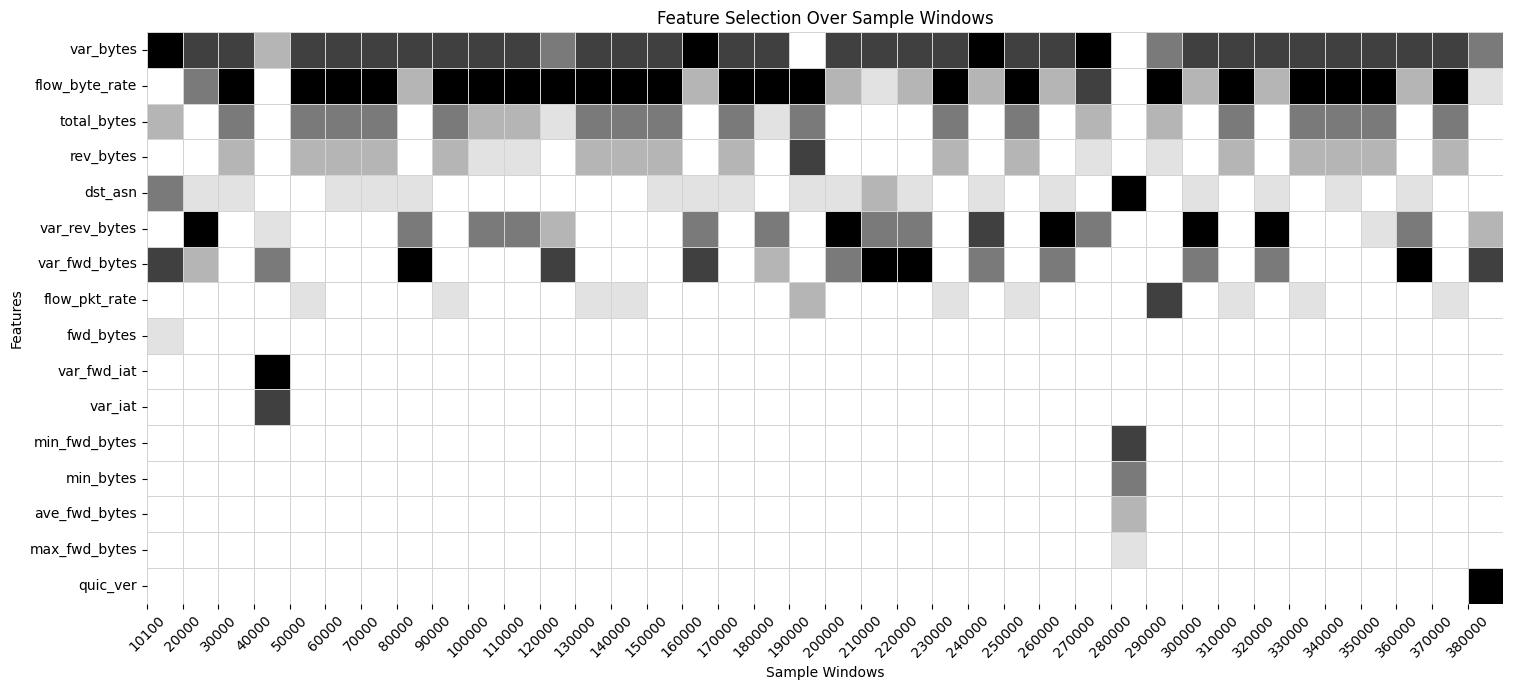

In [26]:
ranking_matrix = get_ranking_matrix(ofs_filled)
plot_heatmap(ranking_matrix)

### FIRES

In [3]:
fires_df = pd.read_csv('sel_features_fires.csv', header=None)
fires_df

,0,1,2,3,4,5,6,7,8,9
0,20,13,1,15,8,16,9,0,19,12
1,20,13,27,1,8,15,9,16,22,38
2,20,13,27,1,8,15,9,16,22,23
3,20,13,27,1,8,15,9,16,22,23
4,20,13,27,1,8,15,6,22,9,16
...,...,...,...,...,...,...,...,...,...,...
379895,44,21,19,18,17,16,15,14,13,12
379896,44,21,19,18,17,16,15,14,13,12
379897,44,21,19,18,17,16,15,14,13,12
379898,44,21,19,18,17,16,15,14,13,12


In [6]:
fires_filtered = fires_df[(fires_df != fires_df.shift()).any(axis=1)]
fires_filtered

,0,1,2,3,4,5,6,7,8,9
0,20,13,1,15,8,16,9,0,19,12
1,20,13,27,1,8,15,9,16,22,38
2,20,13,27,1,8,15,9,16,22,23
4,20,13,27,1,8,15,6,22,9,16
5,20,13,27,1,6,8,15,22,9,16
6,13,20,27,6,1,8,22,15,9,16
9,13,20,27,1,6,8,22,15,9,16
15,13,20,27,6,1,8,22,15,9,16
74,13,20,6,27,1,8,22,15,9,16
9900,17,10,18,11,38,32,24,44,3,33
